In [5]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack

Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [6]:
for i in range(M):
   a = np.zeros(M)
   a[i] = 1
   DCT[:, i] = sp.fftpack.idct(a, norm='ortho')

Generating the 1-D canonical basis

In [7]:
for i in range(M):
    C[i, i] = 1


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

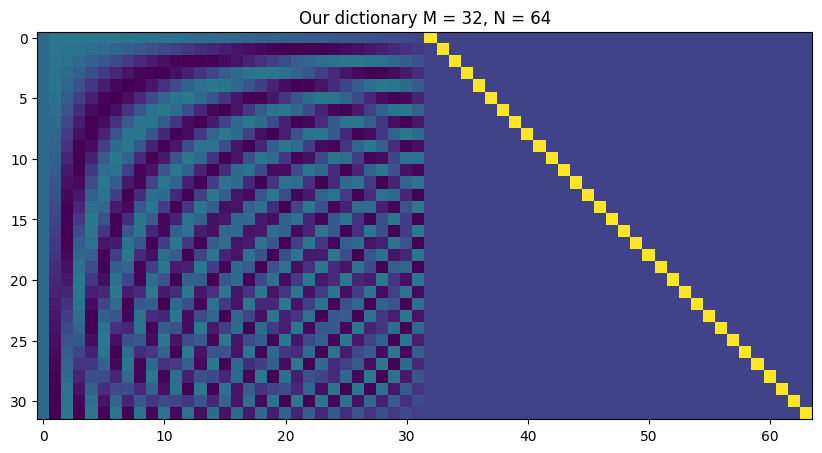

In [8]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to $\mathbf{s}$ that is sparse w.r.t. $C$. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [9]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $DCT$ (make sure the nonzero coefficients are sufficiently large)

In [10]:
def generate_sparse_representation(L, M):
    indexes = np.random.choice(M, L, replace=False)
    #coefficients = np.random.uniform(200, 1000, size=L)
    coefficients = 5*np.random.rand(L)
    x0 = np.zeros(M)
    x0[indexes] = coefficients
    return x0

In [11]:
x0 = generate_sparse_representation(L, N)

Text(0.5, 1.0, 'Original signal')

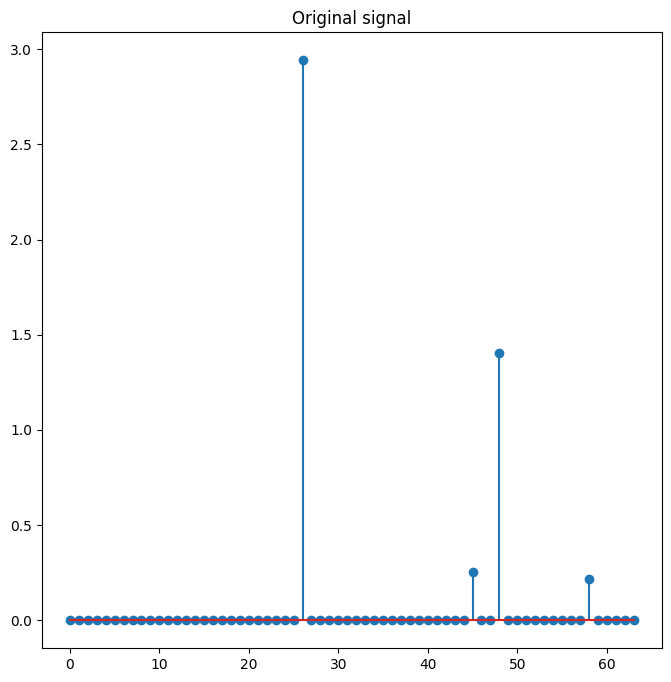

In [12]:
# Plot x0
plt.figure(figsize=(8,8))
plt.stem(x0)
plt.title('Original signal')

Choose spike location

In [13]:
# choose random position from M to N (N = 2M)
spikeLocation = np.random.choice(range(M,N))
#x0[spikeLocation] = np.random.uniform(2000,10000)
lambda_spike = 5 * np.abs(max(x0))
x0[spikeLocation] = lambda_spike

Synthetize the corresponding signal in the signal domain and add noise


In [14]:
s0 = np.dot(D, x0)
s = s0 + np.random.normal(size= s0.shape)*sigma_noise

Plot the sparse signal

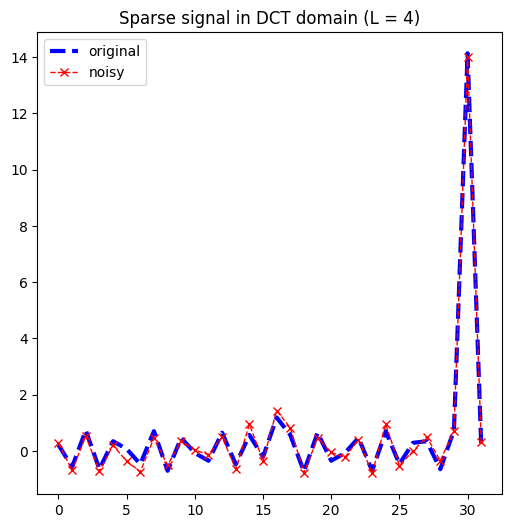

In [15]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [16]:
x_OMP = np.zeros(N)

# residual
r = s

# support set
omega = []

MINIMUM_NORM_RES = 0.1

resNorm = np.linalg.norm(r, 2)

OMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [18]:
while np.count_nonzero(x_OMP) < L and np.linalg.norm(r, 2) > MINIMUM_NORM_RES:#STOPPING CRITERIA:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        e[j] = (resNorm)**2 - (np.dot(r.T, dj)/np.linalg.norm(dj)**2)**2

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    D_omega = D[:, omega]
    D_omega_T_D_omega = np.dot(D_omega.T, D_omega)
    x_OMP[omega] = np.dot(np.linalg.inv(D_omega_T_D_omega), np.dot(D_omega.T, s))

    # update the residual
    r = s - np.dot(D_omega, x_OMP[omega])

    resNorm = np.linalg.norm(r, 2)


In [19]:
print(x_OMP)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49520716  0.          0.          0.          0.          0.
  0.          0.          2.87005003  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.71896483  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         14.68969863  0.        ]


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [20]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x_OMP = np.zeros(N)
  # Support set
  omega = []
  # residual
  r = s
  resNorm = np.linalg.norm(r,2)

  while np.count_nonzero(x_OMP) < L and np.linalg.norm(r, 2) > MINIMUM_NORM_RES:#STOPPING CRITERIA:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        e[j] = (resNorm)**2 - (np.dot(r.T, dj)/np.linalg.norm(dj)**2)**2

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    D_omega = D[:, omega]
    D_omega_T_D_omega = np.dot(D_omega.T, D_omega)
    x_OMP[omega] = np.dot(np.linalg.inv(D_omega_T_D_omega), np.dot(D_omega.T, s))

    # update the residual
    r = s - np.dot(D_omega, x_OMP[omega])

  return x_OMP

In [21]:
s_hat_OMP = np.dot(D, x_OMP)

Show the result

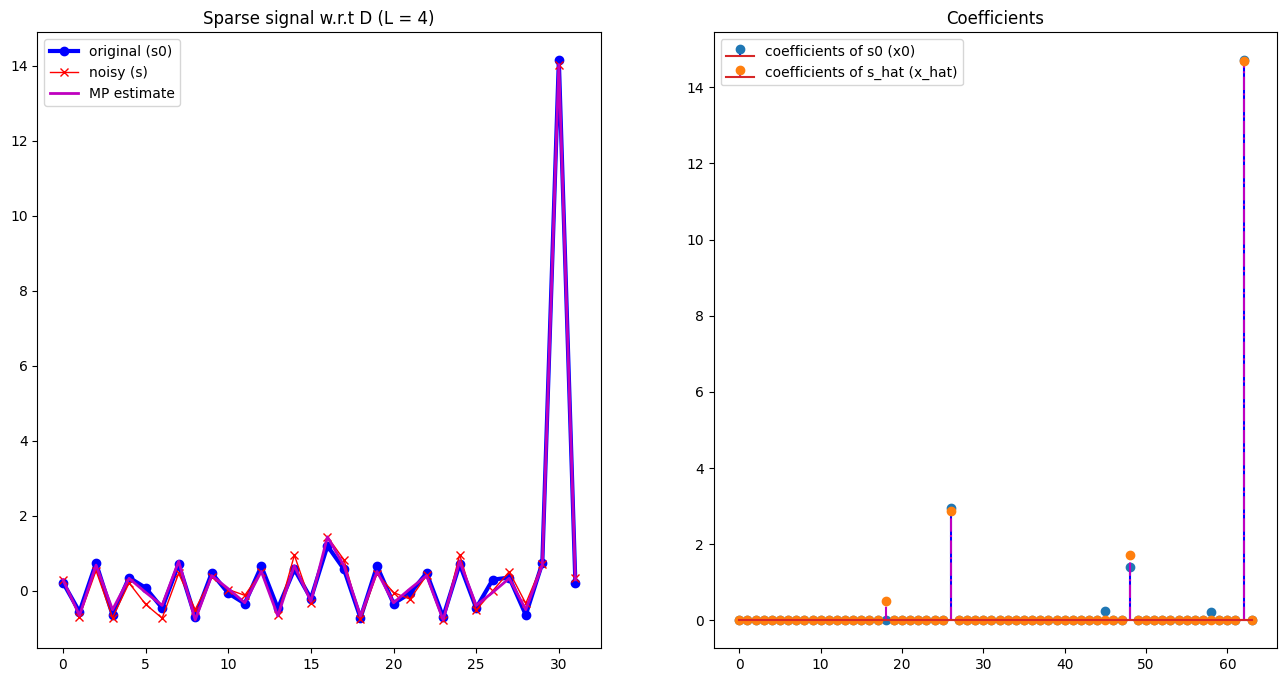

In [22]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [27]:
x_LSOMP = np.zeros(N)

# residual
r = s

# support set
omega = []

MINIMUM_NORM_RES = 0.1

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [29]:
while np.count_nonzero(x_LSOMP) < L and np.linalg.norm(r, 2) > MINIMUM_NORM_RES:# STOPPING CRITERIA:
    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
      e = np.zeros(N)
      # at the first iteration perform the usual sweep step
      for j in range(N):
          dj = D[:, j]
          e[j] = (resNorm)**2 - (np.dot(r.T, dj)/np.linalg.norm(dj)**2)**2
      # find the column of D that matches at best r
      jStar = np.argmin(e)
      # Update the support set with the jstar coefficient
      omega.append(jStar)

      # Update the coefficients by solving the least square problem min ||D_omega x - s ||
      DjStar = D[:, jStar]
      x_LSOMP[jStar] += np.dot(r.T, DjStar)/np.linalg.norm(DjStar)**2
    else:
        # perform the sweep step by solving the LS problem
         e = np.full(N, float('inf'))
         z_u_coefficients = {}
         for j in range(N):
            if j not in omega:
              dj = D[:, j]
              Dw = D[:, omega]
              Dwdj = np.hstack((Dw, dj.reshape(-1, 1)))
              z_u = np.dot(np.linalg.inv(np.dot(Dwdj.T, Dwdj)), np.dot(Dwdj.T, s))
              z_u_coefficients[j] = z_u
              e[j] = np.linalg.norm((s - np.dot(Dwdj, z_u) ),2)**2

         jStar = np.argmin(e)

         # UPDATE the support set with the jStar coefficient
         omega.append(jStar)
         # update the coefficients
         x_LSOMP[omega] = z_u_coefficients[jStar]

    # update the residual
    r = s - np.dot(D, x_LSOMP)



SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [30]:
s_hat_LSOMP = np.dot(D, x_LSOMP)

Show the result

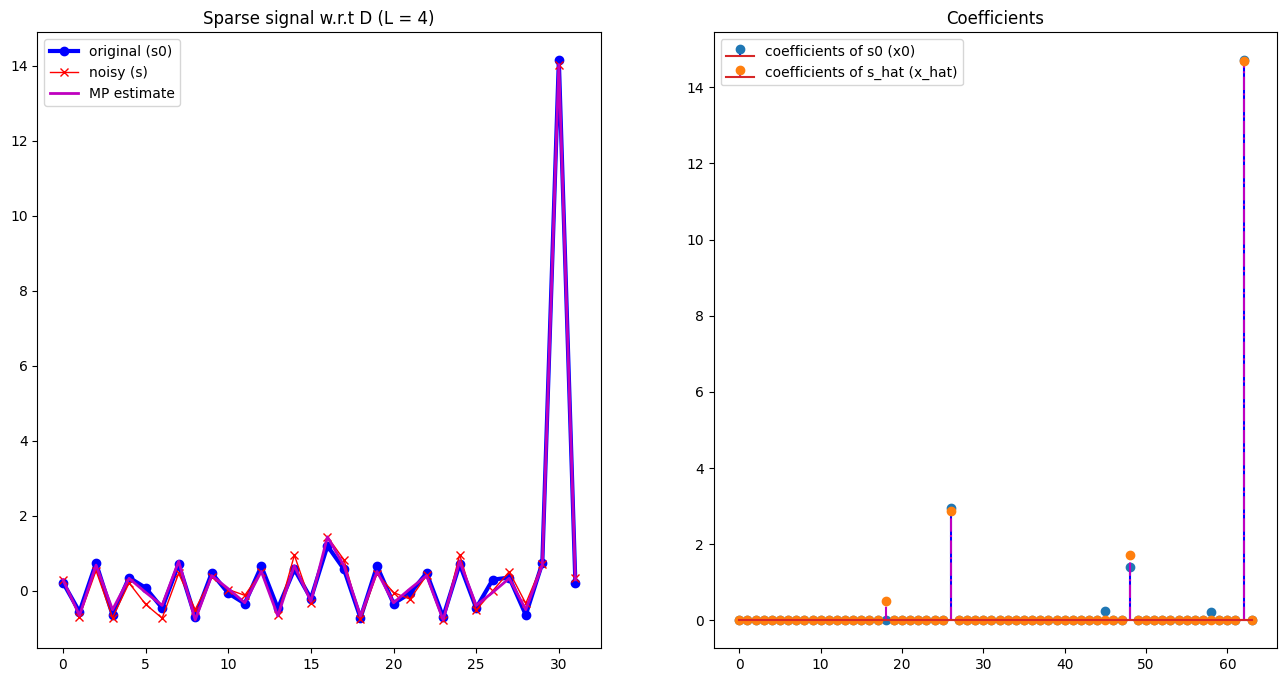

In [31]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])